# Summary of this notebook

In this notebook, we read in data from [all the games played on Lichess.org in July of 2016](https://www.kaggle.com/datasets/arevel/chess-games).  These data consist of about 6.25 million games of chess: the moves made in the game, the time controls set for the game, the date and time when the game took place, a short description of the opening moves of the game (e.g. "Slav Defense"), and a description of how the game ended (e.g. "Normal" or "Time forfeit").  They also include the White and Black players' names, rating scores, and amounts of rating points gained/lost after the game.  Finally, around 15% of games include (inside the list of moves made during the game) a list of Stockfish evaluations for each of the positions that occurred in the game, measured in centipawns of White advantage or number of moves until checkmate.

After cleaning these data of any obvious issues, we extract from the data a list of the "new players".  We define a "new player" to be anyone who had a 1500 rating score (the initial rating score when one joins Lichess.org) during their *first game* of July 2016.  While it is possible that a few players were not new but happened to have a rating score of *exactly 1500* at the start of the month, these players certainly represent a small minority of those we're calling "new players".

After finding all of the new players, we export three CSVs that we will use to train models to predict the outcomes of new players' second games:
1. A CSV containing all the first games of the new players.  This will be used to train our models to predict the outcomes of new players' second games.
2. A CSV containing the outcomes of the second games of all new players.
3. A CSV containing the games played by the *opponents of the new players* (in CSV number 2 above) that were played *immediately before they faced off against a new player* in CSV number 2 above.  This will also be used to predict the outcomes of new players' second games.

The *index* of each such CSV will be the names of the distinct "new players."  This 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from stockfish import Stockfish
import chess

import copy

### Ignore `FutureWarning`s in this notebook

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Import

In [3]:
df = pd.read_csv('../data/chess_games.csv')
df.head(2)

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN
0,Classical,eisaaaa,HAMID449,1-0,2016.06.30,22:00:01,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...
1,Blitz,go4jas,Sergei1973,0-1,2016.06.30,22:00:01,1641,1627,-11.0,12.0,C20,King's Pawn Opening: 2.b3,300+0,Normal,1. e4 e5 2. b3 Nf6 3. Bb2 Nc6 4. Nf3 d6 5. d3 ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6256184 entries, 0 to 6256183
Data columns (total 15 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Event            object 
 1   White            object 
 2   Black            object 
 3   Result           object 
 4   UTCDate          object 
 5   UTCTime          object 
 6   WhiteElo         int64  
 7   BlackElo         int64  
 8   WhiteRatingDiff  float64
 9   BlackRatingDiff  float64
 10  ECO              object 
 11  Opening          object 
 12  TimeControl      object 
 13  Termination      object 
 14  AN               object 
dtypes: float64(2), int64(2), object(11)
memory usage: 716.0+ MB


In [5]:
df.isnull().sum()

Event                 0
White                 0
Black                 0
Result                0
UTCDate               0
UTCTime               0
WhiteElo              0
BlackElo              0
WhiteRatingDiff    4668
BlackRatingDiff    4668
ECO                   0
Opening               0
TimeControl           0
Termination           0
AN                    0
dtype: int64

In [6]:
#Are all the rows that are missing a WhiteRatingDiff also missing a BlackRatingDiff (and conversely)?
#If so, this should output 4668
len(df[(df['WhiteRatingDiff'].isnull()) & (df['BlackRatingDiff'].isnull())])

4668

It seems that the only columns that are sometimes missing values are the `WhiteRatingDiff` and `BlackRatingDiff` columns, which represent how many rating points were gained/lost by White and Black (respectively) after the game in question.  Do these missing values actually mean that zero points were gained/lost?  Or do they mean that something went wrong with that game?

## Games with a zero `WhiteRatingDiff`

In [7]:
df[df['WhiteRatingDiff']==0].head(3)

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN
274,Blitz,cyclo,Quentinovich,1/2-1/2,2016.06.30,22:01:18,2097,2108,0.0,-1.0,B15,Caro-Kann Defense: Rasa-Studier Gambit,180+0,Time forfeit,1. d4 d5 2. f3 c6 3. e4 dxe4 4. Nc3 e5 5. d5 N...
354,Blitz,Diogenus,novichokk,1/2-1/2,2016.06.30,22:01:44,1722,1737,0.0,-1.0,D20,Queen's Gambit Accepted: Saduleto Variation,300+0,Time forfeit,1. d4 d5 2. c4 dxc4 3. e4 e6 4. Bxc4 c5 5. d5 ...
377,Blitz,amnezia,sdgent81,1/2-1/2,2016.06.30,22:01:54,1977,1988,0.0,0.0,B00,Owen Defense,300+0,Time forfeit,1. e4 b6 2. Bc4 Bb7 3. Nc3 e5 4. Nf3 Nf6 5. Nx...


So there are certainly games (tied games, in particular) where both players gained 0.0 rating points.  So what is going on with the games that are missing values for `WhiteRatingDiff` and `BlackRatingDiff`?

## Dropping games with a *missing* `WhiteRatingDiff` (and `BlackRatingDiff`)

In [8]:
df[df['WhiteRatingDiff'].isnull()].head(3)

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN
205,Blitz,irakli112233,irakli1811,1-0,2016.06.30,22:00:54,1500,1500,NaN,NaN,A00,Van't Kruijs Opening,300+0,Normal,1. e3 f5 2. d3 g5 3. Qh5# 1-0
388,Blitz,irakli112233,irakli1811,1-0,2016.06.30,22:01:59,1500,1500,NaN,NaN,C57,"Italian Game: Two Knights Defense, Fried Liver...",300+0,Normal,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Ng5 d5 5. ex...
3352,Blitz,ZUMOSOL,pawnimpact0007,1-0,2016.06.30,22:19:53,2180,1393,NaN,NaN,A40,Englund Gambit Complex: Soller Gambit,300+0,Normal,1. d4 e5 2. dxe5 f6 3. exf6 Nxf6 4. Bg5 Bc5 5....


These games appear to be missing a `WhiteRatingDiff` and a `BlackRatingDiff` because Lichess thinks that something strange happened in the course of the game.  For example, the first game in this list is between "irakli112233" and "irakli1811", which suggests that the two accounts are owned by the same person.  They appear to be cooperating (or perhaps are robots that are currently very bad at the game), as the game is over in just a few moves:

In [9]:
df.loc[205, 'AN']

'1. e3 f5 2. d3 g5 3. Qh5# 1-0'

Other such games were among those that were automatically evaluated by Stockfish and were determined to contain a lot of "surprising" moves.  It is not always entirely clear why some of these games did not result in missing values for `WhiteRatingDiff` or `BlackRatingDiff`, but we will assume that the code on Lichess.org has a better understanding of which games are "invalid" than we can gain by just looking at a few of these games.

For these reasons, we will drop those rows that have a missing `WhiteRatingDiff` or `BlackRatingDiff`.  This shouldn't be too much of a problem, as we are dropping only about 75 of every 100,000 games in our data set this way:

In [10]:
len(df[df['WhiteRatingDiff'].isnull()]) / len(df)

0.0007461417375192289

In [11]:
#Drop those games missing a `WhiteRatingDiff` or `BlackRatingDiff`
df.dropna(inplace=True)

# Distirubtion of Event Types

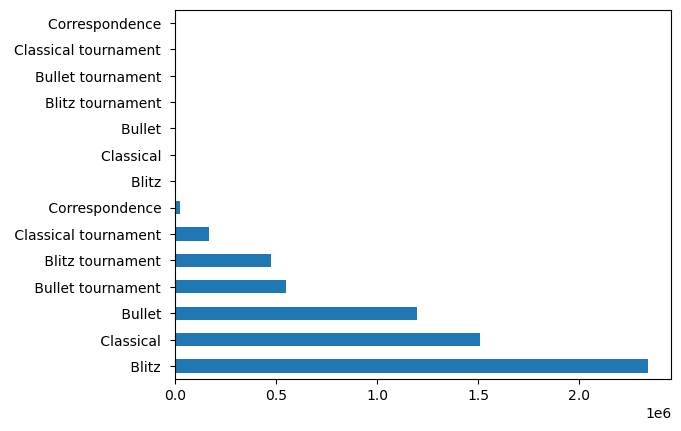

In [12]:
df['Event'].value_counts().plot(kind='barh');

We will restrict attention to the non-tournament, non-Correspondence games.  ("Correspondence" games are played over the course of many days.)  Thus, we will keep only those rows whose `Event` is Classical, Blitz or Bullet.

In [13]:
df['Event'].value_counts().index[0]

' Blitz '

Furthermore, there is something weird going on with the naming of these events.  It appears that nearly all events are named like ' Classical ' or ' Blitz ' (with a space at either end) but a few are named differently.  We will drop those rows whose `Event` value is named differently, and then we will format the remaining `Event` values to no longer contain leading and trailing spaces.

In [14]:
df = df[ df['Event'].isin([' Classical ', ' Blitz ', ' Bullet ']) ]

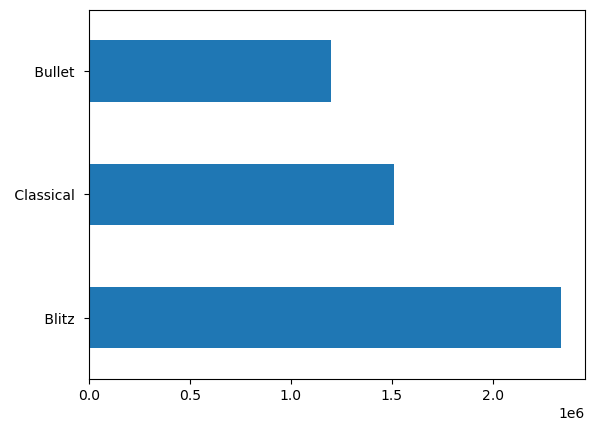

In [15]:
df['Event'].value_counts().plot(kind='barh');

In [16]:
#Format the names of the events
df['Event'] = df['Event'].map({' Blitz ':'Blitz', ' Classical ':'Classical', ' Bullet ':'Bullet'})

## Convert the date and time columns to datetimes and timestamps, then drop unnecessary columns

We will drop the `ECO` column (a code for a categorical description of the opening moves of the game) as well as the `Opening` column (an English description of the opening).

In [17]:
df['datetime'] = df.apply(lambda row : f"{row['UTCDate']} {row['UTCTime']}", axis=1)
df['datetime'] = pd.to_datetime(df['datetime'])
df['timestamp'] = df['datetime'].map(lambda x : x.timestamp())
df = df.drop(columns = ['UTCDate', 'UTCTime', 'ECO', 'Opening'])
df.head(1)

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp
0,Classical,eisaaaa,HAMID449,1-0,1901,1896,11.0,-11.0,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...,2016-06-30 22:00:01,1.467324e+09


## Get the timestamps of the games played by each of the players

In [18]:
#Get the names of all players who were part of a match in our data set
names = set(df['White']).union(set(df['Black']))

In [19]:
#How many distinct players have played a game in our month of data?
len(names)

114939

In [20]:
#Make a dictionary mapping these players' names to lists of times when they played the games
game_times = {}
#Initialize empty lists of game times for each player
for name in names:
    game_times[name]=[]

#Loop over the rows of the dataframe and record the times of the games in each player's entry in the dictionary
for _, row in df.iterrows():
    white_name = row['White']
    black_name = row['Black']
    game_times[white_name].append(row['timestamp'])
    game_times[black_name].append(row['timestamp'])
    
#Sort the game times for each player
for name in names:
    game_times[name] = sorted(game_times[name])

In [21]:
#An example using one of the players in the first game in our dataframe
print(game_times['eisaaaa'])

[1467324001.0, 1467324928.0, 1467325876.0, 1467326444.0, 1467327299.0, 1467327742.0, 1467328304.0, 1467380601.0, 1467381587.0, 1467382475.0, 1467456610.0, 1467457144.0, 1467547984.0, 1467548312.0, 1467550111.0, 1467550879.0, 1467551315.0, 1467673318.0, 1467673526.0, 1467673951.0, 1467674359.0, 1467675032.0, 1467675180.0, 1467675873.0, 1467676192.0, 1467676934.0, 1467677274.0, 1467678030.0, 1467678649.0, 1467678741.0, 1467678968.0, 1467679682.0, 1467679997.0, 1467680277.0, 1467680743.0, 1467681245.0, 1467681722.0, 1468067610.0, 1468184364.0, 1468184785.0, 1468185717.0, 1468187096.0, 1468223481.0, 1468243525.0, 1468252246.0, 1468310226.0, 1468427967.0, 1468528718.0, 1468675911.0, 1468751808.0, 1468753153.0, 1468758257.0, 1468791592.0, 1468792054.0, 1468860169.0, 1469061439.0, 1469104947.0, 1469187837.0, 1469188800.0, 1469189621.0, 1469319905.0, 1469320801.0, 1469399739.0, 1469400360.0, 1469400807.0, 1469401002.0, 1469401771.0, 1469402318.0, 1469402477.0, 1469402900.0, 1469403619.0, 14694

In [22]:
#An example using the opponent from the same game (the first few are
#the same times, but others are not!)
print(game_times['HAMID449'])

[1467324001.0, 1467324928.0, 1467325876.0, 1467381437.0, 1467382057.0, 1467382688.0, 1467389377.0, 1467389945.0, 1467390517.0, 1467475963.0, 1467477354.0, 1467478041.0, 1467479365.0, 1467480330.0, 1467562738.0, 1467563754.0, 1467564355.0, 1467569700.0, 1467571775.0, 1467572601.0, 1467573307.0, 1467658487.0, 1467663170.0, 1467664087.0, 1467746342.0, 1467746788.0, 1467747372.0, 1468524779.0, 1468524983.0, 1468525547.0, 1468526601.0, 1468526949.0, 1468592777.0, 1468594035.0, 1468598335.0, 1468598960.0, 1468600060.0, 1468600706.0, 1468686940.0, 1468688278.0, 1468689575.0, 1468692587.0, 1468692983.0, 1468693227.0, 1468778033.0, 1468778517.0, 1468790540.0, 1468833104.0, 1468863275.0, 1468864270.0, 1468866372.0, 1468866730.0, 1468867066.0, 1468867618.0, 1468868001.0, 1468868575.0, 1468874301.0, 1468876612.0, 1468877800.0, 1468949860.0, 1468951046.0, 1468952210.0, 1469006102.0, 1469007053.0, 1469381887.0, 1469382707.0, 1469387809.0, 1469388438.0, 1469389427.0, 1469389499.0, 1469391800.0, 14694

### Some players have duplicate game timestamps

In [23]:
players_with_duplicate_gametimes = set()

for name in names:
    if len(game_times[name]) != len(set(game_times[name])):
        players_with_duplicate_gametimes.add(name)
        
len(players_with_duplicate_gametimes), len(players_with_duplicate_gametimes)/len(names)

(726, 0.006316393913293138)

We see that a small fraction (about 0.6%) of the players in our data set have two or more games recorded to have taken place at the *exact same second*.  This is possible since Lichess.org allows players to play multiple games at the same time!

The only cases where the presence of multiple identical timestamps for a given player can cause us a problem are the following:
1. New players whose first three games contain duplicate timestamps: this makes it impossible to determine precisely which games were that player's first and second games.
2. Any player X who is the 2nd-game opponent of a given new player Y and for whom it's ambiguous which game X played *immediately before* playing that new player Y.  (This can occur when X's list of game times prior to the time when she played Y has no unique maximum.)

Cases of type 1 above will prevent us from being able to attempt the prediction problem "predict the outcome of a player's 2nd game given information from her 1st game and her to-be opponent's previous game."  We drop from our data set all such cases of type 1 (see below).

However, cases of type 2 do *not* pose an issue to this prediction problem, so long as we are willing to interpret the "opponent's previous game" as "any game played immediately before the timestamp of the game against the new player."  This change of interpretation is of much less importance for the opponents' games than it would be for the new players' first and second games; indeed, the difference between any two of an *established player's* recent games is likely to be not so great while the difference between e.g. the *second* and *third* games of a new player might be quite large.  And indeed, any player who is playing multiple games at once is very likely to be an established player.

For this reason, rather than dropping *all* of the players who have duplicate game times, we will drop only those that constitute cases of type 1 above.  (However, the code below will still function perfectly if one were to right now drop *all* players with duplicate timestamps.)

## Find the new players

New players on Lichess begin with a rating of 1500.  Let's get a list of the names of the players who had a rating of 1500 in their *earliest game in the dataset*.  Although there might be a couple of these players who are actualy *not* new to Lichess, such players would need to have had a rating of *exactly 1500* at the time of *exactly their first game of the month*.

So we will be content to define "new players" as those who had a 1500 rating during their *first game in our data set*.

### Be mindful of players whose 1st three games contain multiple games with the same timestamp

A few players have multiple different games taking place at the same time.  We will not consider these players when looking for "new players", as it's unclear which games are their "first" and "second" games.

For example, the following is someone who would (otherwise) be considered a "new player" but whose second and third games of the month have an identical timestamp:

In [24]:
game_times['antyha'][:3]

[1468018880.0, 1468020730.0, 1468020730.0]

In [25]:
#Initialize a list of row indices for rows that contain a new player's first game
#(that is, rows where some player has a 1500 rating and it's her first game).
#Also, initialize a set of new players' names
new_player_inds = []
new_player_names = set()

#Keep track of how many otherwise "new players" we're excluding since their
#first 3 games contain duplicate timestamps
players_with_duplicate_times = []

#Loop over the rows of our dataframe
for ind, row in df.iterrows():
    white_name = row['White']
    black_name = row['Black']
    white_is_new = False
    black_is_new = False
    
    #If this is the White player's first game AND she has a 1500 rating, we'll say that White is "new"
    if (row['timestamp'] == game_times[white_name][0]) and (row['WhiteElo']==1500):
        white_is_new = True
    #Similarly for Black
    if (row['timestamp'] == game_times[black_name][0]) and (row['BlackElo']==1500):
        black_is_new = True
    
    #If this is the White player's first game, 
    #AND if her first three games all had distinct timestamps,
    #then add her name to our set of new players' names
    if white_is_new:
        if len(set(game_times[white_name][:3])) == len(game_times[white_name][:3]):
            new_player_names.add(white_name)
        #Record her name if she has duplicate timestamps
        else:
            players_with_duplicate_times.append(white_name)
        
    #Similarly for Black
    if black_is_new:
        if len(set(game_times[black_name][:3])) == len(game_times[black_name][:3]):
            new_player_names.add(black_name)
        else:
            players_with_duplicate_times.append(black_name)
    
    #Finally, if AT LEAST ONE of the players is new, remember the index of the row
    if white_is_new or black_is_new:
        new_player_inds.append(ind)

In [26]:
#How many otherwise "new players" did we exclude because of duplicate
#timestamps in that player's first 3 games?
len(players_with_duplicate_times)

7

In [27]:
new_players_first_games = df.loc[new_player_inds, :]

Text(0.5, 1.0, 'Distribution of event types played by new players in their first games')

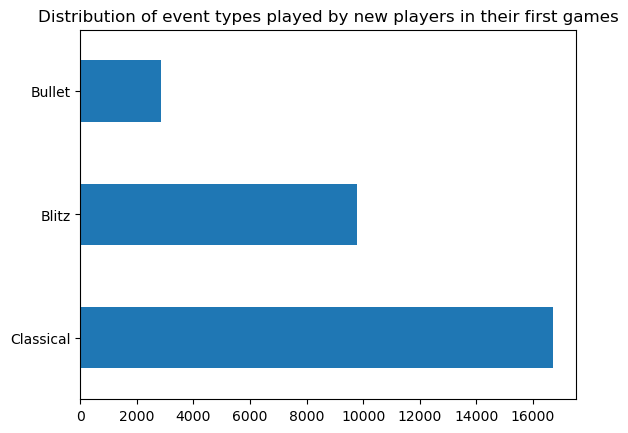

In [28]:
#Look at the distribution of game types played by new players in their first games
new_players_first_games['Event'].value_counts().plot(kind='barh');
plt.title("Distribution of event types played by new players in their first games")

Now that we have a list of all the new players, we need to restrict attention to those new players who went on to play *at least 2 games during the month*.  This is because we are trying to predict the outcome of new players' *second* games given the moves in their *first* games.

We also need to find the names of the *second-game opponents* of the new players.  This is because we will use information about these players' previous games to help predict the outcome of the new player's second game.

In [29]:
#How many "new players" do we have?
len(new_player_names)

29599

In [30]:
#How many new players went on to play a second game?
new_played2 = {name for name in new_player_names if len(game_times[name])>1}
len(new_played2)

24284

## Aside: an example illustrating the method we'll use below

In [31]:
#Initialize a new dataframe that has the same columns as df plus a couple new ones
test = df.iloc[0:0,:]
test['test_col'] = pd.Series()
test['test_col2'] = pd.Series()
test

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,test_col,test_col2


In [32]:
#Copy the first two rows of df TWICE each.  For the first copy, assign a test_col value of 0
#and leave the test_col2 value empty (NaN).  For the second copy, assign a test_col value of 1
#and a test_col2 value of 'cool'
for _, row in df.iloc[0:2, :].iterrows():
    current_row = copy.deepcopy(row)
    current_row['test_col'] = 0
    
    duplicate_row = copy.deepcopy(current_row)
    duplicate_row['test_col'] = 1
    duplicate_row['test_col2'] = 'cool'
    
    test = test.append(current_row, ignore_index=True)
    test = test.append(duplicate_row, ignore_index=True)

test  

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,test_col,test_col2
0,Classical,eisaaaa,HAMID449,1-0,1901,1896,11.0,-11.0,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...,2016-06-30 22:00:01,1.467324e+09,0.0,NaN
1,Classical,eisaaaa,HAMID449,1-0,1901,1896,11.0,-11.0,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...,2016-06-30 22:00:01,1.467324e+09,1.0,cool
2,Blitz,go4jas,Sergei1973,0-1,1641,1627,-11.0,12.0,300+0,Normal,1. e4 e5 2. b3 Nf6 3. Bb2 Nc6 4. Nf3 d6 5. d3 ...,2016-06-30 22:00:01,1.467324e+09,0.0,NaN
3,Blitz,go4jas,Sergei1973,0-1,1641,1627,-11.0,12.0,300+0,Normal,1. e4 e5 2. b3 Nf6 3. Bb2 Nc6 4. Nf3 d6 5. d3 ...,2016-06-30 22:00:01,1.467324e+09,1.0,cool


# Extracting the new players' 1st and 2nd games into separate dataframes

In [33]:
#Initialize empty dataframes with the same columns as our df
new_pl_1st_games = df.iloc[0:0,:]
new_pl_2nd_games = df.iloc[0:0,:]

#Add a column to indicate the name of the player who is new and who is playing
#her first (second) game.  In case BOTH players are new and playing their first (second)
#game, we will duplicate the row (and out the OTHER player's name in the new_pl_name column there).
#See the example above.
new_pl_1st_games['name_of_pl_playing_1st_game'] = pd.Series()
new_pl_2nd_games['name_of_pl_playing_1st_game'] = pd.Series()
new_pl_1st_games['name_of_pl_playing_2nd_game'] = pd.Series()
new_pl_2nd_games['name_of_pl_playing_2nd_game'] = pd.Series()

#In case both players are new and playing their 1st (2nd) game, we'll record this.
#(In particular, this makes identifying duplicated rows easier.)
new_pl_1st_games['both_players_1st_game'] = pd.Series()
new_pl_2nd_games['both_players_1st_game'] = pd.Series()
new_pl_1st_games['both_players_2nd_game'] = pd.Series()
new_pl_2nd_games['both_players_2nd_game'] = pd.Series()

In [34]:
new_pl_1st_games

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,name_of_pl_playing_1st_game,name_of_pl_playing_2nd_game,both_players_1st_game,both_players_2nd_game


In [35]:
new_pl_2nd_games

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,name_of_pl_playing_1st_game,name_of_pl_playing_2nd_game,both_players_1st_game,both_players_2nd_game


In [36]:
#Initialize a dictionary of the form {new_player_name : 2nd_game_opponent_name}
new_pl_2nd_game_opponents = {}
#Keep track of the times of the second games, so that we can later find the opponent's
#game that immediately preceded this game (if it exists)
#This dictionary looks like {new_player_name : timestamp_of_her_2nd_game}
new_pl_2nd_game_times = {}


#Loop over the rows of our dataframe
for ind, row in df.iterrows():
    white_name = row['White']
    black_name = row['Black']
    
    #If neither player is one of the players who is new this month and will go on to play
    #at least 2 games this month, then skip this row
    if (white_name not in new_played2) and (black_name not in new_played2):
        continue
    
    #Make booleans that say, for each player, whether that player is new and playing her
    #first (second) game
    if white_name in new_played2:
        white_1st_game = int(row['timestamp'] == game_times[white_name][0])
        white_2nd_game = int(row['timestamp'] == game_times[white_name][1])
    else:
        white_1st_game = 0
        white_2nd_game = 0
            
    if black_name in new_played2:
        black_1st_game = int(row['timestamp'] == game_times[black_name][0])
        black_2nd_game = int(row['timestamp'] == game_times[black_name][1])
    else:
        black_1st_game = 0
        black_2nd_game = 0
        
        
        
    #If neither player is new and playing her 1st/2nd game, we can skip this row
    if not (white_1st_game or white_2nd_game or black_1st_game or black_2nd_game):
        continue
        
        
    #Otherwise, extract a copy of the current row as a series so that we can add it to the
    #appropriate dataframe(s) (with appropriate modification)
    current_row = copy.deepcopy(row)
    
    
    
    #If BOTH players are new players who are playing their FIRST game, then record
    #this row TWICE in the new_pl_1st_games dataframe (with W and B's names 
    #as the 'name_of_pl_playing_1st_game' value, respectively):
    if white_1st_game and black_1st_game:
        current_row['both_players_1st_game'] = 1
        current_row['name_of_pl_playing_1st_game'] = white_name
        
        row_duplicate = copy.deepcopy(current_row)
        row_duplicate['name_of_pl_playing_1st_game'] = black_name
        
        new_pl_1st_games = new_pl_1st_games.append(current_row, ignore_index=True)
        new_pl_1st_games = new_pl_1st_games.append(row_duplicate, ignore_index=True)
        
        
        
    #If BOTH players are new players who are playing their SECOND game, then record
    #this row TWICE in the new_pl_2nd_games dataframe (with W and B's names 
    #as the 'name_of_pl_playing_2nd_game' value, respectively):
    elif white_2nd_game and black_2nd_game:
        current_row['both_players_2nd_game'] = 1
        current_row['name_of_pl_playing_2nd_game'] = white_name
        
        row_duplicate = copy.deepcopy(current_row)
        row_duplicate['name_of_pl_playing_2nd_game'] = black_name
        
        new_pl_2nd_games = new_pl_2nd_games.append(current_row, ignore_index=True)
        new_pl_2nd_games = new_pl_2nd_games.append(row_duplicate, ignore_index=True)
        
        #Also, record BOTH players in our dict of 2nd-game opponents of new players:
        new_pl_2nd_game_opponents[white_name] = black_name
        new_pl_2nd_game_opponents[black_name] = white_name

        new_pl_2nd_game_times[white_name] = row['timestamp']
        new_pl_2nd_game_times[black_name] = row['timestamp']
    
    
    
    #Otherwise, exactly one player is new and playing her first game OR exactly one player is new
    #and playing her second game (or both).  We follow the same method as above, but now we don't
    #need to worry about having to duplicate the row.
    else:
        
        if white_1st_game:
            current_row['name_of_pl_playing_1st_game'] = white_name
            new_pl_1st_games = new_pl_1st_games.append(current_row, ignore_index=True)
            
        if black_1st_game:
            current_row['name_of_pl_playing_1st_game'] = black_name
            new_pl_1st_games = new_pl_1st_games.append(current_row, ignore_index=True)
        
        if white_2nd_game:
            current_row['name_of_pl_playing_2nd_game'] = white_name
            new_pl_2nd_games = new_pl_2nd_games.append(current_row, ignore_index=True)
            
            new_pl_2nd_game_opponents[white_name] = black_name
            new_pl_2nd_game_times[white_name] = row['timestamp']
            
        if black_2nd_game:
            current_row['name_of_pl_playing_2nd_game'] = black_name
            new_pl_2nd_games = new_pl_2nd_games.append(current_row, ignore_index=True)
            
            new_pl_2nd_game_opponents[black_name] = white_name
            new_pl_2nd_game_times[black_name] = row['timestamp']


In [37]:
new_pl_1st_games.head(1)

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,name_of_pl_playing_1st_game,name_of_pl_playing_2nd_game,both_players_1st_game,both_players_2nd_game
0,Classical,fabikim,sereno,1-0,1630,1500,7.0,-7.0,420+5,Normal,1. e4 e5 2. Nf3 d6 3. Bc4 Nc6 4. d3 Na5 5. Na3...,2016-06-30 22:00:02,1.467324e+09,sereno,NaN,NaN,NaN


In [38]:
new_pl_2nd_games.head(1)

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,name_of_pl_playing_1st_game,name_of_pl_playing_2nd_game,both_players_1st_game,both_players_2nd_game
0,Blitz,Kevpod,ale19,0-1,1500,1412,-222.0,9.0,300+1,Time forfeit,1. d4 { [%eval 0.2] } 1... Nf6 { [%eval 0.2] }...,2016-06-30 22:06:12,1.467324e+09,NaN,Kevpod,NaN,NaN


In [39]:
#Total number of new players who played at least two games in our data (see earlier)
len(new_played2)

24284

In [40]:
#Number of new players whose 1st adn 2nd games we actually recorded (respectively)
len(new_pl_1st_games), len(new_pl_2nd_games)

(24284, 24284)

In [41]:
#Number of new players whose 2nd-game timestamps and opponent names we recorded (respectively)
len(new_pl_2nd_game_times), len(new_pl_2nd_game_opponents)

(24284, 24284)

## Exporting these dataframes as CSVs

Before exporting, we should do three things:
1. Drop unnecessary columns.
2. Fill in missing values with 0s (see below).
3. Change the index of each dataframe to be the name of the *new player* who is playing her 1st or 2nd game.

### Drop unnecessary columns

In [42]:
new_pl_1st_games.drop(columns=['name_of_pl_playing_2nd_game',
                              'both_players_2nd_game'],
                      inplace=True)

new_pl_2nd_games.drop(columns=['name_of_pl_playing_1st_game',
                              'both_players_1st_game'],
                      inplace=True)

In [43]:
new_pl_1st_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24284 entries, 0 to 24283
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Event                        24284 non-null  object        
 1   White                        24284 non-null  object        
 2   Black                        24284 non-null  object        
 3   Result                       24284 non-null  object        
 4   WhiteElo                     24284 non-null  int64         
 5   BlackElo                     24284 non-null  int64         
 6   WhiteRatingDiff              24284 non-null  float64       
 7   BlackRatingDiff              24284 non-null  float64       
 8   TimeControl                  24284 non-null  object        
 9   Termination                  24284 non-null  object        
 10  AN                           24284 non-null  object        
 11  datetime                     24284 non-nu

In [44]:
new_pl_2nd_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24284 entries, 0 to 24283
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Event                        24284 non-null  object        
 1   White                        24284 non-null  object        
 2   Black                        24284 non-null  object        
 3   Result                       24284 non-null  object        
 4   WhiteElo                     24284 non-null  int64         
 5   BlackElo                     24284 non-null  int64         
 6   WhiteRatingDiff              24284 non-null  float64       
 7   BlackRatingDiff              24284 non-null  float64       
 8   TimeControl                  24284 non-null  object        
 9   Termination                  24284 non-null  object        
 10  AN                           24284 non-null  object        
 11  datetime                     24284 non-nu

### Fill in missing values with 0s

The only column in the `new_pl_1st_games` dataframe that contains any missing values is the `both_players_1st_game` column (which merely indicates whether a given row is a matchup between *two* new players, and hence should also appear once elsewhere in the dataframe with the only difference being the name in the `name_of_pl_playing_1st_game` column).  We constructed this column so that it contains a 1 if both players are playing their first game an contains *no value* otherwise.  So we should simply fill in all its missing values with 0.

Similarly, the `new_pl_2nd_games` dataframe is onlu missing values in `both_players_2nd_game`, and these should be filled in with 0s.

In [45]:
new_pl_1st_games.fillna(0, inplace=True)
new_pl_2nd_games.fillna(0, inplace=True)

In [46]:
#Change these 0s and 1s into ints
new_pl_1st_games['both_players_1st_game'] = new_pl_1st_games['both_players_1st_game'].astype(int)
new_pl_2nd_games['both_players_2nd_game'] = new_pl_2nd_games['both_players_2nd_game'].astype(int)

### Change the index of each dataframe to be the name of the new player

In [47]:
new_pl_1st_games.set_index('name_of_pl_playing_1st_game', inplace=True)
new_pl_2nd_games.set_index('name_of_pl_playing_2nd_game', inplace=True)

In [48]:
new_pl_1st_games.head(1)

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,both_players_1st_game
name_of_pl_playing_1st_game,,,,,,,,,,,,,,
sereno,Classical,fabikim,sereno,1-0,1630,1500,7.0,-7.0,420+5,Normal,1. e4 e5 2. Nf3 d6 3. Bc4 Nc6 4. d3 Na5 5. Na3...,2016-06-30 22:00:02,1.467324e+09,0


In [49]:
new_pl_2nd_games.head(1)

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,both_players_2nd_game
name_of_pl_playing_2nd_game,,,,,,,,,,,,,,
Kevpod,Blitz,Kevpod,ale19,0-1,1500,1412,-222.0,9.0,300+1,Time forfeit,1. d4 { [%eval 0.2] } 1... Nf6 { [%eval 0.2] }...,2016-06-30 22:06:12,1.467324e+09,0


### Export as CSVs

In [50]:
#Check if these two dataframes have the same unique players in their index sets
players1 = set(new_pl_1st_games.index)
players2 = set(new_pl_2nd_games.index)
players2==players1

True

In [51]:
#Check that no player appears more than once in the index
len(new_pl_1st_games.index) == len(set(new_pl_1st_games.index))

True

In [52]:
#Since all is good, export the dataframes as CSVs
new_pl_1st_games.to_csv('../data/processed/new_pl_1st_games.csv', index_label='name_of_pl_playing_1st_game')
new_pl_2nd_games.to_csv('../data/processed/new_pl_2nd_games.csv', index_label='name_of_pl_playing_2nd_game')

# Find the games played by the second-game opponents of the new players *immediately before* that new player's second game

In [53]:
#Make a dictionary whose KEYS are the names "X" of the 2nd-game opponents of the new players
#and whose VALUES are sets of the new players for whom "X" will be the second opponent.
#This will enable faster lookup based on the (2nd-game) OPPONENTS of the new players.

opp_names_dict = {}

opp_names = set(new_pl_2nd_game_opponents.values())
for opp_name in opp_names:
    #Initialize empty sets
    opp_names_dict[opp_name] = set()

#Loop over the new players
for new_player in new_pl_2nd_game_opponents.keys():
    #Record the second-game opponent of this new player
    opp_2nd_game = new_pl_2nd_game_opponents[new_player]
    #Add this new player to that opponent's set in the dictionary
    opp_names_dict[opp_2nd_game].add(new_player)

In [54]:
#An example: Who are all of the new players for whom the player named "Deathclaw"
#serves as their second opponent ever?
opp_names_dict['Deathclaw']

{'deiaa11', 'lucasruaa5'}

In [55]:
#How many distinct players are there among the second-game opponents of the new players?
len(opp_names_dict)

17001

In [56]:
#Do we still have each new player's second game recorded exactly once?
#If so, then this cell should output the same number as len(new_played2) above
sum([len(opp_names_dict[x]) for x in opp_names_dict.keys()])

24284

### Get the timestamps of the new players' 2nd-game opponents' immediately-previous games (if they exist)

As we discussed earlier in this notebook, we will not concern ourselves with the possibility that some such opponent has multiple games with the same immediately-prior-to-facing-the-new-player timestamp.  We will simply pick any one of these games whose timestamp immediately precedes the timestamp of the game against the new player; we will call the game we picked the "opponent's most recent previous game."  This is hardly an untruth, as it is *one of* that opponent's immediately-previous games! 

In [57]:
#Initialize a dictionary of dictionaries
opp_previous_games_dict = {opp : {} for opp in opp_names_dict.keys()}
#Initialize sets
new_players_whose_2nd_opponents_have_no_previous_game = set()
new_players_whose_2nd_opponents_have_a_previous_game = set()

for opp in opp_names_dict.keys():
    for new_player in opp_names_dict[opp]:
        #Get the game time of the new player's 2nd game
        gametime_2nd = game_times[new_player][1]
        #Get all of the game times for that new player's 2nd-game opponent that are earlier (or equal to)
        #the time of the new player's 2nd game
        opp_earlier_gametimes = [x for x in game_times[opp] if x < gametime_2nd]
        
        #If that 2nd-game opponent has NO earlier games, then record a "N/A" for this new player and
        #record the name of the new player
        if len(opp_earlier_gametimes) == 0:
            opp_previous_games_dict[opp][new_player] = 'N/A'
            new_players_whose_2nd_opponents_have_no_previous_game.add(new_player)
        #Otherwise, take the most recent of these prior games
        else:
            opp_previous_games_dict[opp][new_player] = opp_earlier_gametimes[-1]
            new_players_whose_2nd_opponents_have_a_previous_game.add(new_player)
        

In [58]:
#What are the timestamps of the games that the player "Deathclaw" played
#immediately prior to facing the new players (in those new players' 2nd games)?
opp_previous_games_dict['Deathclaw']

{'lucasruaa5': 1468561735.0, 'deiaa11': 1469481019.0}

In [59]:
#How many new players have a 2nd-game opponent who had played no previous games that month?
len(new_players_whose_2nd_opponents_have_no_previous_game)

465

In [60]:
#Check that there are no new players in common between those we've sorted as "2nd-game opponent
#has no previous game" and those we've sorted as "2nd-game opponent has a previous game"
len(new_players_whose_2nd_opponents_have_no_previous_game.intersection(new_players_whose_2nd_opponents_have_a_previous_game))

0

In [61]:
#Do we still have each new player recorded exactly once?
#If so, then this cell should output the same number as len(new_played2) above
len(new_players_whose_2nd_opponents_have_a_previous_game) + len(new_players_whose_2nd_opponents_have_no_previous_game)

24284

In [62]:
#How many of these second-round opponents of new players have non-distinct game timestamps
#among the timestamps we found for the games they played immediately before playing a new
#player (in that new player's 2nd game)?
bad_opps = set()

for opp in opp_names_dict.keys():
    distinct_times = set(opp_previous_games_dict[opp].values())
    if len(distinct_times) != len(opp_previous_games_dict[opp]):
        bad_opps.add(opp)
        
len(bad_opps)

0

Since there are no "bad opponents" in this sense, we need not worry about duplicate timestamps in the code that appears below (in the large cell that loops through the rows of the dataframe).  Basically, we don't need to worry that a player like "Deathclaw" (who constitutes the 2nd-game opponent of multiple new players) has non-distinct game timestamps among those games played "immediately prior" to playing a new player (as a 2nd-game opponent).

### Create a dataframe of the 2nd-game opponents' previous games

In [63]:
new_pl_2nd_opp_previous_games = df.iloc[0:0,:]

new_pl_2nd_opp_previous_games['user_to_play_new_pl'] = pd.Series()
new_pl_2nd_opp_previous_games['new_pl_to_play'] = pd.Series()
new_pl_2nd_opp_previous_games['both_users_to_play_new_pl_next'] = pd.Series()
new_pl_2nd_opp_previous_games['2nd_game_opp_had_no_previous_game'] = pd.Series()

new_pl_2nd_opp_previous_games

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,user_to_play_new_pl,new_pl_to_play,both_users_to_play_new_pl_next,2nd_game_opp_had_no_previous_game


In [64]:
#Loop over the rows of our dataframe
for ind, row in df.iterrows():
    white_name = row['White']
    black_name = row['Black']
    timestamp = row['timestamp']
    
    #If neither player is a second-game opponent of a new player, skip this row
    if (white_name not in opp_names_dict.keys()) and (black_name not in opp_names_dict.keys()):
        continue
        
        
    #For each player, determine if this is a game after which that player will play a new player
    #(in that new player's 2nd game)
    
    #Initialize booleans
    white_about_to_play_new_pl = 0
    black_about_to_play_new_pl = 0
    
    #Start with the White player
    if white_name in opp_names_dict.keys():
        #Get the names of all the new players for whom this player will be the 2nd-game opponent
        new_players = opp_names_dict[white_name]
        #For each such new player, check whether this game has the correct timestamp to be
        #that opponent's immediately-previous game
        for new_player in new_players:
            if opp_previous_games_dict[white_name][new_player] == timestamp:
                #If so, update our boolean to 1 and record the name of that new player
                white_about_to_play_new_pl = 1
                new_pl_who_white_is_about_to_play = new_player
                break
    
    #Do similarly for the Black player
    if black_name in opp_names_dict.keys():
        new_players = opp_names_dict[black_name]
        for new_player in new_players:
            if opp_previous_games_dict[black_name][new_player] == timestamp:
                black_about_to_play_new_pl = 1
                new_pl_who_black_is_about_to_play = new_player
                break
        
        
        
    #If neither player is about to play a new player (in that new player's 2nd game), skip this row:
    if not (white_about_to_play_new_pl or black_about_to_play_new_pl):
        continue
        
        
    #Otherwise, extract a copy of the current row as a series so that we can add it to our dataframe
    #that we're going to output
    current_row = copy.deepcopy(row)

    
    
    
    #If BOTH players are about to play a new player (in that new player's 2nd game), then record
    #this row TWICE in the new_pl_2nd_opp_previous_games dataframe (with W and B's names 
    #as the 'user_to_play_new_pl' value, respectively; and with the appropriate new players
    #as the 'new_pl_to_play' values):
    if white_about_to_play_new_pl and black_about_to_play_new_pl:    
        current_row['both_users_to_play_new_pl_next'] = 1
        current_row['user_to_play_new_pl'] = white_name
        current_row['new_pl_to_play'] = new_pl_who_white_is_about_to_play
        
        row_duplicate = copy.deepcopy(current_row)
        row_duplicate['user_to_play_new_pl'] = black_name
        row_duplicate['new_pl_to_play'] = new_pl_who_black_is_about_to_play
        
        new_pl_2nd_opp_previous_games = new_pl_2nd_opp_previous_games.append(current_row, ignore_index=True)
        new_pl_2nd_opp_previous_games = new_pl_2nd_opp_previous_games.append(row_duplicate, ignore_index=True)
        
            
    
    #Otherwise, exactly one player is about to play a new player (in that new player's 2nd game).
    #We follow the same method as above, but now we don't need to worry about having to duplicate the row.
    else:
        
        if white_about_to_play_new_pl:
            current_row['user_to_play_new_pl'] = white_name
            current_row['new_pl_to_play'] = new_pl_who_white_is_about_to_play
            new_pl_2nd_opp_previous_games = new_pl_2nd_opp_previous_games.append(current_row, ignore_index=True)
            
        if black_about_to_play_new_pl:
            current_row['user_to_play_new_pl'] = black_name
            current_row['new_pl_to_play'] = new_pl_who_black_is_about_to_play
            new_pl_2nd_opp_previous_games = new_pl_2nd_opp_previous_games.append(current_row, ignore_index=True)


In [65]:
new_pl_2nd_opp_previous_games.head(1)

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,user_to_play_new_pl,new_pl_to_play,both_users_to_play_new_pl_next,2nd_game_opp_had_no_previous_game
0,Classical,Claudiosparov,gonzo0506,0-1,1432,1355,-14.0,13.0,600+0,Normal,1. a3 d5 2. b4 b5 3. Bb2 Nc6 4. e3 e5 5. d4 e4...,2016-06-30 22:01:02,1.467324e+09,gonzo0506,farfalla,NaN,NaN


### Checking that everything worked correctly

In [66]:
#How many new players were there who go on to play at least 2 games in our month of data?
len(new_played2)

24284

In [67]:
#How many of these new players had 2nd-game opponents who had not played ANY games previously that month?
len(new_players_whose_2nd_opponents_have_no_previous_game)

465

In [68]:
#How many games did we record (above) as the "Games of 2nd-game opponents of new players
#that those opponents played immediately before playing the new player (in her 2nd game)"?
len(new_pl_2nd_opp_previous_games)

23823

In [69]:
#Do the last two add up correctly?  That is, when we add them up, do we get
#the same number as the number of of new players who played at least 2 games?
len(new_players_whose_2nd_opponents_have_no_previous_game) + len(new_pl_2nd_opp_previous_games) - len(new_played2)

4

It seems that we somehow recorded *4 too many* games as "games of 2nd-game opponents of new players that those opponents played immediately before playing the new player (in her 2nd game)".  That is, some new players must have *multiple games* recorded as their 2nd-game opponent's "immediately previous" game.  Who are these new players?

In [70]:
new_pl_2nd_opp_previous_games['new_pl_to_play'].value_counts()

ivthelove         3
Najanchess1991    2
mr-bakeer         2
PabloJVivanco2    1
mkulltra          1
                 ..
chonowotos        1
omiddastjerdi     1
calhi             1
plokhov_ea        1
x12361            1
Name: new_pl_to_play, Length: 23819, dtype: int64

As we can see, the 4 "extra" games come from the following:
- New player `ivthelove` has 3 distinct games recorded as her "2nd-game opponent's immediately previous game."
- New player `mr-bakeer` has 2 distinct games recorded as her "2nd-game opponent's immediately previous game."
- New player `Najanchess1991` has 2 distinct games recorded as her "2nd-game opponent's immediately previous game."

In each case, the new player should only have *one* distinct game recorded.  Hence, we have 2+1+1 = 4 too many games recorded.  Let's take a look at these games that we recorded as "2nd-game opponent's immediately previous game" for each of these 3 new players:

In [71]:
# "ivthelove"
new_pl_2nd_opp_previous_games[new_pl_2nd_opp_previous_games['new_pl_to_play']=='ivthelove']

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,user_to_play_new_pl,new_pl_to_play,both_users_to_play_new_pl_next,2nd_game_opp_had_no_previous_game
21287,Classical,mostafaaa,mohsen_kabootarian,0-1,1723,2156,-2.0,2.0,600+2,Time forfeit,1. e4 e5 0-1,2016-07-28 20:04:54,1.469736e+09,mohsen_kabootarian,ivthelove,NaN,NaN
21288,Classical,mostafaaa,mohsen_kabootarian,0-1,1723,2156,-2.0,3.0,600+2,Time forfeit,1. e4 e5 0-1,2016-07-28 20:04:54,1.469736e+09,mohsen_kabootarian,ivthelove,NaN,NaN
21289,Classical,mostafaaa,mohsen_kabootarian,0-1,1723,2156,-2.0,3.0,600+2,Normal,1. e4 e5 2. Bc4 Nf6 3. Nf3 Nc6 4. c3 Nxe4 5. d...,2016-07-28 20:04:54,1.469736e+09,mohsen_kabootarian,ivthelove,NaN,NaN


In [72]:
# "mr-bakeer"
new_pl_2nd_opp_previous_games[new_pl_2nd_opp_previous_games['new_pl_to_play']=='mr-bakeer']

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,user_to_play_new_pl,new_pl_to_play,both_users_to_play_new_pl_next,2nd_game_opp_had_no_previous_game
19160,Bullet,lolchezz,TaaronV,0-1,1837,1870,-11.0,14.0,60+0,Time forfeit,1. e3 c5 0-1,2016-07-26 01:39:00,1.469497e+09,TaaronV,mr-bakeer,NaN,NaN
19161,Bullet,lolchezz,TaaronV,1-0,1837,1870,12.0,-14.0,60+0,Normal,1. e3 { [%eval 0.15] } 1... c5 { [%eval 0.17] ...,2016-07-26 01:39:00,1.469497e+09,TaaronV,mr-bakeer,NaN,NaN


In [73]:
# "Najanchess1991"
new_pl_2nd_opp_previous_games[new_pl_2nd_opp_previous_games['new_pl_to_play']=='Najanchess1991']

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,user_to_play_new_pl,new_pl_to_play,both_users_to_play_new_pl_next,2nd_game_opp_had_no_previous_game
6306,Blitz,inaciodias,Bidwill,0-1,1658,1635,-11.0,12.0,300+0,Normal,1. e4 e5 0-1,2016-07-09 00:16:11,1.468023e+09,Bidwill,Najanchess1991,NaN,NaN
6307,Blitz,Bidwill,lemonia,0-1,1635,1653,-10.0,11.0,300+0,Normal,1. e4 c5 2. Bc4 d6 3. d4 cxd4 4. Qxd4 Nf6 5. e...,2016-07-09 00:16:11,1.468023e+09,Bidwill,Najanchess1991,NaN,NaN


### Dropping "fake" games

As we can see by looking at the `AN` column of each of these new players' 2nd-game opponents' "immediately previous" games, *all but one of the games last no more than 2 turns before being terminated*.  So we can assume that in each of these cases, the "real" game is the one that lasts longer than 2 turns.

Thus, we will eliminate the 4 "fake" games from our `new_pl_2nd_opp_previous_games` dataframe.  Before actually doing so, let's make a new dataframe called `dropped` where we perform the drop.  After checking that everything looks correct, we will re-assign our `new_pl_2nd_opp_previous_games` dataframe to equal `dropped`.

In [74]:
dropped = new_pl_2nd_opp_previous_games.drop([21287, 21288, 19160, 6306])

Let's check that the proper games were kept:

In [75]:
dropped[dropped['new_pl_to_play']=='ivthelove']

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,user_to_play_new_pl,new_pl_to_play,both_users_to_play_new_pl_next,2nd_game_opp_had_no_previous_game
21289,Classical,mostafaaa,mohsen_kabootarian,0-1,1723,2156,-2.0,3.0,600+2,Normal,1. e4 e5 2. Bc4 Nf6 3. Nf3 Nc6 4. c3 Nxe4 5. d...,2016-07-28 20:04:54,1.469736e+09,mohsen_kabootarian,ivthelove,NaN,NaN


In [76]:
dropped[dropped['new_pl_to_play']=='mr-bakeer']

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,user_to_play_new_pl,new_pl_to_play,both_users_to_play_new_pl_next,2nd_game_opp_had_no_previous_game
19161,Bullet,lolchezz,TaaronV,1-0,1837,1870,12.0,-14.0,60+0,Normal,1. e3 { [%eval 0.15] } 1... c5 { [%eval 0.17] ...,2016-07-26 01:39:00,1.469497e+09,TaaronV,mr-bakeer,NaN,NaN


In [77]:
dropped[dropped['new_pl_to_play']=='Najanchess1991']

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,user_to_play_new_pl,new_pl_to_play,both_users_to_play_new_pl_next,2nd_game_opp_had_no_previous_game
6307,Blitz,Bidwill,lemonia,0-1,1635,1653,-10.0,11.0,300+0,Normal,1. e4 c5 2. Bc4 d6 3. d4 cxd4 4. Qxd4 Nf6 5. e...,2016-07-09 00:16:11,1.468023e+09,Bidwill,Najanchess1991,NaN,NaN


In [78]:
#Re-assign `new_pl_2nd_opp_previous_games` to be the dataframe where we dropped the "fake" games
new_pl_2nd_opp_previous_games = dropped

Finally, let's check one more time that everything adds up correctly:

In [79]:
len(new_players_whose_2nd_opponents_have_no_previous_game) + len(new_pl_2nd_opp_previous_games) - len(new_played2)

0

## Exporting this dataframe as a CSV

Before exporting this dataframe, there are a few things we must do:
1. Fill in missing values with 0s (see below).
2. For each new player whose name does not appear in this index (i.e., those new players whose 2nd-game opponents had *no previous games this month*), add a row to the dataframe corresponding to this new player.  Leave the added row empty other than setting the value of `2nd_game_opp_had_no_previous_game` to 1.
3. Change the index of the dataframe to be the name of the *new player* who will be played in the next game of the "opponent" in the current game.

### Fill in the missing values with zeros

In [80]:
new_pl_2nd_opp_previous_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23819 entries, 0 to 23822
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Event                              23819 non-null  object        
 1   White                              23819 non-null  object        
 2   Black                              23819 non-null  object        
 3   Result                             23819 non-null  object        
 4   WhiteElo                           23819 non-null  int64         
 5   BlackElo                           23819 non-null  int64         
 6   WhiteRatingDiff                    23819 non-null  float64       
 7   BlackRatingDiff                    23819 non-null  float64       
 8   TimeControl                        23819 non-null  object        
 9   Termination                        23819 non-null  object        
 10  AN                                

Because of how we've set things up, the only cases where a value could be missing is if it's a boolean that's supposed to be 0.  Indeed, *all* the values in the column `2nd_game_opp_had_no_previous_game` are missing since the only rows in our dataframe (so far) correspond to new players whose 2nd-game opponents *did* have a previous game this month; all such games should have a value of 0 in the `2nd_game_opp_had_no_previous_game` column.  Similarly, the only other missing values are in the `both_users_to_play_new_pl_next` column; the ones that are missing correspond to all the games where it was *not* the case that both users are about to play a new player (in that new player's 2nd game).  So all missing values should be filled with 0s:

In [81]:
new_pl_2nd_opp_previous_games.fillna(0, inplace=True)

In [82]:
#Change the types of the bool columns to ints
new_pl_2nd_opp_previous_games['both_users_to_play_new_pl_next'] = new_pl_2nd_opp_previous_games['both_users_to_play_new_pl_next'].astype(int)
new_pl_2nd_opp_previous_games['2nd_game_opp_had_no_previous_game'] = new_pl_2nd_opp_previous_games['2nd_game_opp_had_no_previous_game'].astype(int)

### Add in empty rows for the new players whose 2nd-game opponents had no previous games this month

#### An example of how we'll add these "empty rows"

In [83]:
example_df = new_pl_2nd_opp_previous_games.head(1)
example_df

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,user_to_play_new_pl,new_pl_to_play,both_users_to_play_new_pl_next,2nd_game_opp_had_no_previous_game
0,Classical,Claudiosparov,gonzo0506,0-1,1432,1355,-14.0,13.0,600+0,Normal,1. a3 d5 2. b4 b5 3. Bb2 Nc6 4. e3 e5 5. d4 e4...,2016-06-30 22:01:02,1.467324e+09,gonzo0506,farfalla,0,0


In [84]:
for new_player in new_players_whose_2nd_opponents_have_no_previous_game:
    row_to_add = pd.Series()
    row_to_add['new_pl_to_play'] = new_player
    row_to_add['2nd_game_opp_had_no_previous_game'] = 1
    row_to_add['both_users_to_play_new_pl_next'] = 0
    
    example_df = example_df.append(row_to_add, ignore_index=True)
    
    #Just add the first of the "new players whose 2nd opponents have no previous game", then break
    break
    
#Scroll to the last few columns of example_df to see the non-missing values
example_df

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,user_to_play_new_pl,new_pl_to_play,both_users_to_play_new_pl_next,2nd_game_opp_had_no_previous_game
0,Classical,Claudiosparov,gonzo0506,0-1,1432.0,1355.0,-14.0,13.0,600+0,Normal,1. a3 d5 2. b4 b5 3. Bb2 Nc6 4. e3 e5 5. d4 e4...,2016-06-30 22:01:02,1.467324e+09,gonzo0506,farfalla,0,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,xmen3000,0,1


#### Add the "new players whose 2nd opponents have no previous game" to our dataframe

In [85]:
for new_player in new_players_whose_2nd_opponents_have_no_previous_game:
    row_to_add = pd.Series()
    row_to_add['new_pl_to_play'] = new_player
    row_to_add['2nd_game_opp_had_no_previous_game'] = 1
    row_to_add['both_users_to_play_new_pl_next'] = 0
    
    new_pl_2nd_opp_previous_games = new_pl_2nd_opp_previous_games.append(row_to_add, ignore_index=True)

In [86]:
#Check that our dataframe now has the same number of rows as there are new players who play at least 2 games
len(new_pl_2nd_opp_previous_games) == len(new_played2)

True

In [87]:
#Check that we have the correct number of rows in this dataframe corresponding to new players
#whose 2nd-game opponents had no previous game this month
len(new_pl_2nd_opp_previous_games[new_pl_2nd_opp_previous_games['2nd_game_opp_had_no_previous_game']!=0])

465

### Change the index of the dataframe to be the name of the new player who will be played against next game

In [88]:
#Rename a couple columns to make their meanings clearer
new_pl_2nd_opp_previous_games.rename(columns={'new_pl_to_play':'new_pl_to_be_played_next_game',
                                      'user_to_play_new_pl':'user_to_play_new_pl_next_game'},
                                    inplace=True)

In [89]:
new_pl_2nd_opp_previous_games.set_index('new_pl_to_be_played_next_game', inplace=True)

In [90]:
new_pl_2nd_opp_previous_games.head(1)

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,user_to_play_new_pl_next_game,both_users_to_play_new_pl_next,2nd_game_opp_had_no_previous_game
new_pl_to_be_played_next_game,,,,,,,,,,,,,,,,
farfalla,Classical,Claudiosparov,gonzo0506,0-1,1432.0,1355.0,-14.0,13.0,600+0,Normal,1. a3 d5 2. b4 b5 3. Bb2 Nc6 4. e3 e5 5. d4 e4...,2016-06-30 22:01:02,1.467324e+09,gonzo0506,0,0


In [91]:
#How many "new players" are accounted for in the index of this new dataframe?
len(new_pl_2nd_opp_previous_games.index)

24284

In [92]:
#Check that no player appears more than once in the dataframe's index
len(new_pl_2nd_opp_previous_games.index) == len(set(new_pl_2nd_opp_previous_games.index))

True

In [93]:
#Check that we have exactly the same distinct players as our set of "new players
#who have played at least 2 games this month"
set(new_pl_1st_games.index) == set(new_played2)

True

In [94]:
new_pl_2nd_opp_previous_games.to_csv('../data/processed/new_pl_2nd_opp_previous_games.csv', index_label='new_pl_to_be_played_next_game')

# Converting 'AN' column to sequences of moves

'AN' stands for [Algebraic Notation](https://en.wikipedia.org/wiki/Algebraic_notation_(chess)).

In [44]:
#An example game
df.loc[6246093, 'AN']

'1. e4 e5 2. Nf3 Nf6 3. Nxe5 Nxe4 4. Qe2 Qe7 5. Qxe4 d6 6. d4 dxe5 7. dxe5 Qb4+ 8. Qxb4 Bxb4+ 9. Bd2 a5 10. Bxb4 axb4 11. Nd2 Bf5 12. O-O-O O-O 13. b3 Rxa2 14. Kb1 Rxc2 15. Ka1 Rd8 16. Bc4 Nc6 17. Nf3 Ra8+ 18. Kb1 Rxc4+ 19. Kb2 Rc2+ 20. Kb1 Rxf2+ 21. Kc1 Ra1# 0-1'

A "+" means Check and a "#" means Checkmate.  An equals sign (=) indicates a promotion of a pawn into the piece after the equals sign.  A '0-0' indicates a king-side Castle, and a '0-0-0' indicates a queen-side Castle.

In [45]:
#An example game that comes with Stockfish evaluation numbers
df.loc[6248556, 'AN']

'1. c4 { [%eval 0.04] } 1... g6 { [%eval 0.51] } 2. Nc3 { [%eval 0.26] } 2... Bg7 { [%eval 0.38] } 3. d4 { [%eval 0.38] } 3... d6 { [%eval 0.43] } 4. Nf3 { [%eval 0.45] } 4... Nf6 { [%eval 0.56] } 5. e4 { [%eval 0.38] } 5... Bg4 { [%eval 0.43] } 6. Be3 { [%eval 0.35] } 6... O-O { [%eval 0.43] } 7. Be2 { [%eval 0.43] } 7... Nc6 { [%eval 0.77] } 8. O-O { [%eval 0.46] } 8... a6 { [%eval 0.85] } 9. h3?! { [%eval 0.22] } 9... Bxf3 { [%eval 0.24] } 10. Bxf3 { [%eval 0.17] } 10... Qc8?! { [%eval 0.87] } 11. Be2 { [%eval 0.38] } 11... Nd8?! { [%eval 1.16] } 12. d5 { [%eval 1.01] } 12... Ne8 { [%eval 1.27] } 13. Qb3 { [%eval 1.1] } 13... c5 { [%eval 1.27] } 14. a4 { [%eval 1.21] } 14... Nc7 { [%eval 1.7] } 15. a5 { [%eval 1.68] } 15... Rb8 { [%eval 1.8] } 16. Rfd1 { [%eval 1.43] } 16... b5 { [%eval 1.43] } 17. axb6 { [%eval 1.35] } 17... Na8 { [%eval 1.39] } 18. Qc2 { [%eval 1.35] } 18... Rxb6 { [%eval 1.5] } 19. Bg5 { [%eval 1.36] } 19... Qb7 { [%eval 1.65] } 20. Na4 { [%eval 1.67] } 20... Bxb

Here, the items in braces are the Stockfish evaluations in centipawns of white advantage (or in number of moves until a checkmate, at the end of the game).  Annotations like "??" and "?!" are simply Stockfish automatically stating which moves are bad / surprising.  Thus, to extract just the *moves* from the game, we should ignore these annotations as well as anything in braces.

In [57]:
#An example game that ends in a draw
df.loc[274, 'AN']

'1. d4 d5 2. f3 c6 3. e4 dxe4 4. Nc3 e5 5. d5 Nf6 6. Bg5 Bb4 7. fxe4 Qa5 8. Bxf6 Bxc3+ 9. Ke2 Bxb2 10. Bxg7 Rg8 11. Rb1 Bd4 12. Bh6 cxd5 13. exd5 Qxd5 14. Nf3 Bg4 15. Rb3 e4 16. Re3 Nc6 17. h3 O-O-O 18. hxg4 exf3+ 19. gxf3 Bxe3 20. Qxd5 Rxd5 21. Bxe3 Re8 22. Kf2 Ra5 23. Bc4 b5 24. Bb3 Ne5 25. Rxh7 Re7 26. Rh8+ Kd7 27. Rb8 Nc4 28. Bg5 Re5 29. f4 Rd5 30. Rb7+ Kc6 31. Rxf7 Rd2+ 32. Kg3 Ra6 33. Rf6+ Kb7 34. Rf7+ Kc8 35. Rf8+ Kd7 36. a4 bxa4 37. Bxc4 a3 38. Rf7+ Ke8 39. Re7+ Kf8 40. Bxa6 a2 41. Bf6 Rxc2 42. Bd3 Rc3 43. Kh4 a1=Q 44. Bxc3 Qxc3 45. Bf5 Qf6+ 46. g5 Qxe7 47. Kh5 a5 48. g6 Qg7 49. Kg5 Ke7 50. Be6 Qf6+ 51. Kh6 Kxe6 52. Kh7 Qg7+ 53. Kxg7 Kf5 54. Kh7 Kxf4 55. g7 a4 56. g8=Q a3 57. Qa2 Ke5 58. Qxa3 Kd4 59. Qa4+ Ke5 1/2-1/2'

In [41]:
def remove_braces(s):
    '''
    Removes any segments of the string s that are in braces.  For example,
    'This {is a} message { }' becomes 'This  message '.
    '''
    is_brace = 0
    output = ''
    for i in range(len(s)):
        if s[i]=='{':
            is_brace = 1
        if is_brace == 0:
            output += s[i]
            continue
        else:
            if s[i] == '}':
                is_brace=0
                continue
    
    return output

In [42]:
remove_braces(df.loc[6248556, 'AN'])

'1. c4  1... g6  2. Nc3  2... Bg7  3. d4  3... d6  4. Nf3  4... Nf6  5. e4  5... Bg4  6. Be3  6... O-O  7. Be2  7... Nc6  8. O-O  8... a6  9. h3?!  9... Bxf3  10. Bxf3  10... Qc8?!  11. Be2  11... Nd8?!  12. d5  12... Ne8  13. Qb3  13... c5  14. a4  14... Nc7  15. a5  15... Rb8  16. Rfd1  16... b5  17. axb6  17... Na8  18. Qc2  18... Rxb6  19. Bg5  19... Qb7  20. Na4  20... Bxb2?  21. Rab1  21... Bf6?  22. Bxf6  22... Rxb1  23. Rxb1  23... Qd7  24. Bg4  24... Qxa4??  25. Qxa4  25... exf6  26. Qxa6  26... Nc7  27. Qxd6  27... Ne8  28. Qxd8  28... Ng7?!  29. Rb8  29... Rxd8  30. Rxd8+  30... Ne8  31. Rxe8+  31... Kg7  32. d6  32... f5  33. exf5  33... gxf5  34. Bxf5  34... f6  35. d7  35... Kh6  36. d8=Q  36... Kg5  37. Rg8+  37... Kxf5  0-1'

In [43]:
remove_braces(df.loc[6246093, 'AN'])

'1. e4 e5 2. Nf3 Nf6 3. Nxe5 Nxe4 4. Qe2 Qe7 5. Qxe4 d6 6. d4 dxe5 7. dxe5 Qb4+ 8. Qxb4 Bxb4+ 9. Bd2 a5 10. Bxb4 axb4 11. Nd2 Bf5 12. O-O-O O-O 13. b3 Rxa2 14. Kb1 Rxc2 15. Ka1 Rd8 16. Bc4 Nc6 17. Nf3 Ra8+ 18. Kb1 Rxc4+ 19. Kb2 Rc2+ 20. Kb1 Rxf2+ 21. Kc1 Ra1# 0-1'

In [70]:
#Get rid of the move numbers
def remove_numbers(s):
    return re.sub( '\d+\.+' , '', s).lstrip()

In [71]:
#Remove the ending 0-1, 1-0, or 1/2-1/2 from the string
def remove_ending(s):
    if (s[-3:]=='0-1') or (s[-3:]=='1-0'):
        return s[:-3].rstrip()
    elif s[-7:]=='1/2-1/2':
        return s[:-7].rstrip()

In [72]:
#Remove any question marks and exclamation marks
def remove_marks(s):
    return re.sub('(\?|\!)+', '', s)

In [73]:
def format_game(s):
    return remove_marks(remove_ending(remove_numbers(remove_braces(s))))

In [74]:
format_game(df.loc[6248556, 'AN'])

'c4   g6   Nc3   Bg7   d4   d6   Nf3   Nf6   e4   Bg4   Be3   O-O   Be2   Nc6   O-O   a6   h3   Bxf3   Bxf3   Qc8   Be2   Nd8   d5   Ne8   Qb3   c5   a4   Nc7   a5   Rb8   Rfd1   b5   axb6   Na8   Qc2   Rxb6   Bg5   Qb7   Na4   Bxb2   Rab1   Bf6   Bxf6   Rxb1   Rxb1   Qd7   Bg4   Qxa4   Qxa4   exf6   Qxa6   Nc7   Qxd6   Ne8   Qxd8   Ng7   Rb8   Rxd8   Rxd8+   Ne8   Rxe8+   Kg7   d6   f5   exf5   gxf5   Bxf5   f6   d7   Kh6   d8=Q   Kg5   Rg8+   Kxf5'

In [75]:
format_game(df.loc[6246093, 'AN'])

'e4 e5  Nf3 Nf6  Nxe5 Nxe4  Qe2 Qe7  Qxe4 d6  d4 dxe5  dxe5 Qb4+  Qxb4 Bxb4+  Bd2 a5  Bxb4 axb4  Nd2 Bf5  O-O-O O-O  b3 Rxa2  Kb1 Rxc2  Ka1 Rd8  Bc4 Nc6  Nf3 Ra8+  Kb1 Rxc4+  Kb2 Rc2+  Kb1 Rxf2+  Kc1 Ra1#'

### Finding players who had a 1500 rating at any point in the month

In [7]:
white_1500s = df[df['WhiteElo']==1500]
black_1500s = df[df['BlackElo']==1500]

In [8]:
len(white_1500s), len(black_1500s)

(43540, 32326)

It appears that players with a 1500 rating are more likely to be assigned to White than to Black.

We'll now want to restrict attention to those games involving players who had a 1500 rating at some point in the month of data we have.  The easiest way to do this is to concatenate the `white_1500s` and `black_1500s` dataframes we just made, but make sure to avoid duplicating games where *both* players had a rating of 1500.  Specifically, we'll join those games where *Black (and ONLY Black) had a rating of 1500* to those games where White had a rating of 1500 (and Black may or may not have had a 1500 rating):

In [9]:
only_black_1500s = black_1500s[black_1500s['WhiteElo']!=1500]

In [10]:
new_players = pd.concat([white_1500s, only_black_1500s])
new_players.head(2)

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN,datetime,timestamp
198,Blitz tournament,slichess,redscale,1-0,1500,1385,128.0,-16.0,D06,Queen's Gambit Refused: Marshall Defense,180+2,Normal,1. d4 Nf6 2. c4 d5 3. cxd5 Nxd5 4. e4 Nf6 5. N...,2016-06-30 22:00:51,1.467324e+09
205,Blitz,irakli112233,irakli1811,1-0,1500,1500,NaN,NaN,A00,Van't Kruijs Opening,300+0,Normal,1. e3 f5 2. d3 g5 3. Qh5# 1-0,2016-06-30 22:00:54,1.467324e+09


### Keeping only those players who had a 1500 rating in their *first* game of the month

In [11]:
#Get the names of all players who were part of a match involving a 1500-rated player
names = set(new_players['White']).union(set(new_players['Black']))

In [14]:
#Make a dictionary mapping these players' names to lists of times when they played the games
game_times = {}
#Initialize empty lists of game times for each player
for name in names:
    game_times[name]=[]

#Loop over the rows of the dataframe and record the times of the games in each player's entry in the dictionary
for ind in new_players.index:
    row = new_players.loc[ind]
    white_name = row['White']
    black_name = row['Black']
    game_times[white_name].append(row['timestamp'])
    game_times[black_name].append(row['timestamp'])

#### Get the first games of players with 1500 ratings

In [31]:
#Loop over all the rows of our "new_players" dataframe.
#If the row contains only one player with a 1500 rating, and 
    

### Finding the second-game opponents of these players

# NEED TO CHANGE THIS TO REFLECT THAT 'df' NO LONGER IS JUST THE 1500-RANKED PLAYERS

In [28]:
len(df[df['WhiteElo']==1500]), len(df[df['BlackElo']==1500])

(43540, 32326)

Comparing these numbers to the pre-concatenation numbers, it appears we did not lose any games from our data set.

In [30]:
len(df)

73469

In [29]:
len(df[df['WhiteElo']==1500]) + len(df[df['BlackElo']==1500]) - len(df)

2397

We have 73469 games in which at least one player had a rating of 1500.  Among these, 2397 were games where *both* players had a rating of 1500.

## Examining Rating Distributions

<AxesSubplot: ylabel='Frequency'>

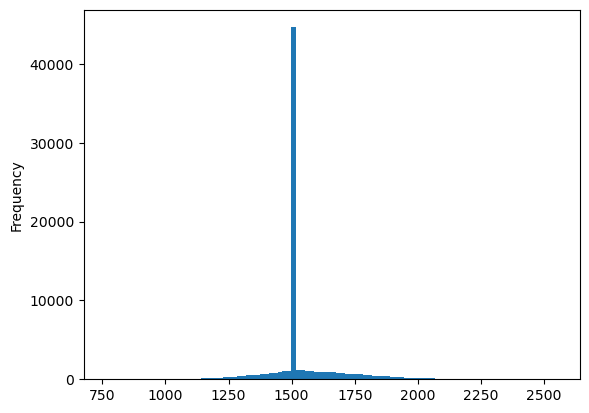

In [31]:
df['WhiteElo'].plot(kind='hist', bins=100)

<AxesSubplot: ylabel='Frequency'>

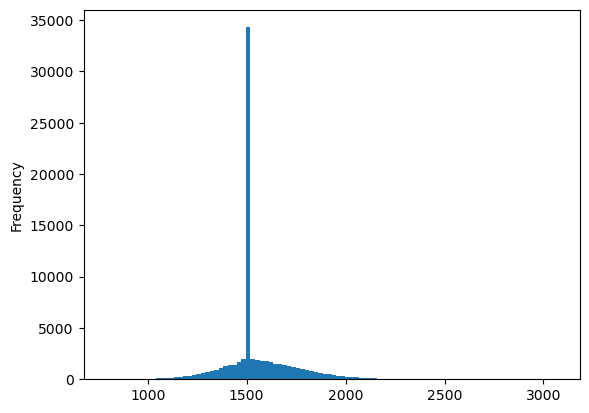

In [32]:
df['BlackElo'].plot(kind='hist', bins=100)

#### Outlier among the Black players?

Black appears to have an extreme outlier on the ratings distribution.  Who is this?

In [41]:
df[df['BlackElo']>2600]

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN
233964,Bullet,RAH--SAEIS,UnVieuxMonsieur,0-1,2016.07.02,03:30:20,1500,3069,-1.0,0.0,A00,Gedult's Opening,30+0,Time forfeit,1. f3?! { [%eval -0.53] } 1... g6?! { [%eval 0...
4133340,Bullet tournament,Tagiyev894,AstanehChess,0-1,2016.07.21,16:12:50,1500,2642,-2.0,0.0,B10,Caro-Kann Defense: Breyer Variation,60+0,Time forfeit,1. e4 c6 2. d3 d5 3. Nc3 g6 4. Nf3 Bg7 5. Be2 ...


It appears to be the player "UnVieuxMonsieur."  Let's find all games in our data set played by this player:

In [42]:
uvm = df[(df['White']=='UnVieuxMonsieur') | (df['Black']=='UnVieuxMonsieur')]
uvm

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN
233964,Bullet,RAH--SAEIS,UnVieuxMonsieur,0-1,2016.07.02,03:30:20,1500,3069,-1.0,0.0,A00,Gedult's Opening,30+0,Time forfeit,1. f3?! { [%eval -0.53] } 1... g6?! { [%eval 0...


So "UnVieuxMonsieur" was *not* a player who had a 1500 rating during the month for which we have data.

### Rating distributions, ignoring 1500 ratings

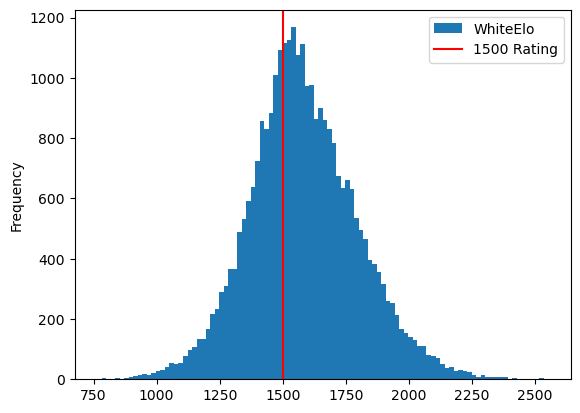

In [38]:
df[df['WhiteElo']!=1500]['WhiteElo'].plot(kind='hist', bins=100)
plt.axvline(x = 1500, color = 'r', label = '1500 Rating')
plt.legend();

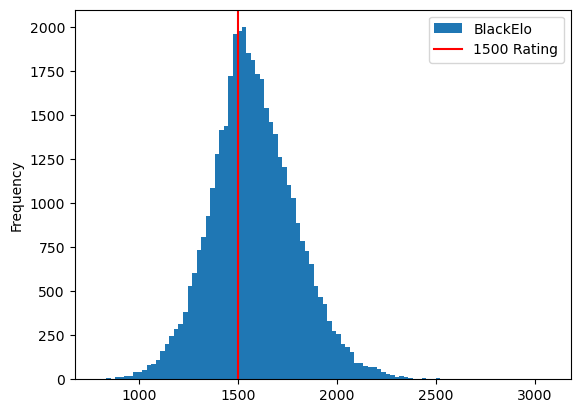

In [39]:
df[df['BlackElo']!=1500]['BlackElo'].plot(kind='hist', bins=100)
plt.axvline(x = 1500, color = 'r', label = '1500 Rating')
plt.legend();

### Rating distribution of new players

The above histograms included both the new players and the *opponents* of the new players.  Let's look only at the ratings of players who had a 1500 rating at some point in the month for which we have data.

In [43]:
white_1500_names = white_1500s['White']
black_1500_names = black_1500s['Black']

In [48]:
names_1500 = set(white_1500_names).union(set(black_1500_names))

In [49]:
len(names)

46341

In [52]:
#Make new columns indicating if the White/Black players had a 1500 rating at some point in the month
df['w_had_1500'] = df['White'].map(lambda x : int(x in names))
df['b_had_1500'] = df['Black'].map(lambda x : int(x in names))

<AxesSubplot: ylabel='Frequency'>

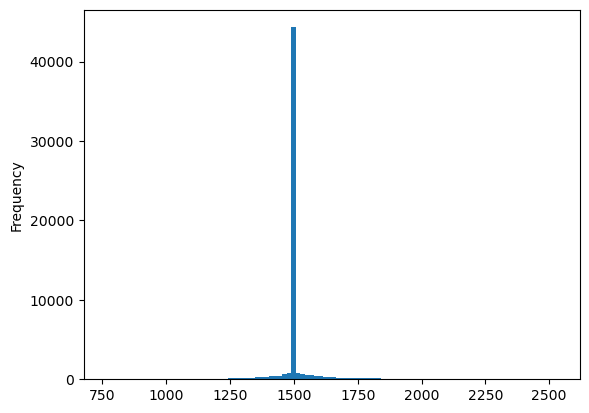

In [53]:
df[df['w_had_1500']==1]['WhiteElo'].plot(kind='hist', bins=100);

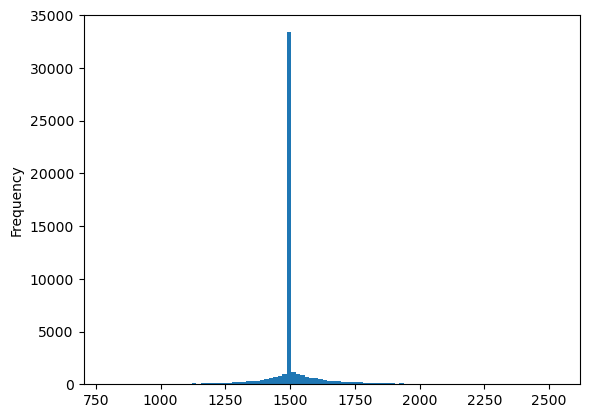

In [55]:
df[df['b_had_1500']==1]['BlackElo'].plot(kind='hist', bins=100);

#### Histograms excluding 1500 ratings

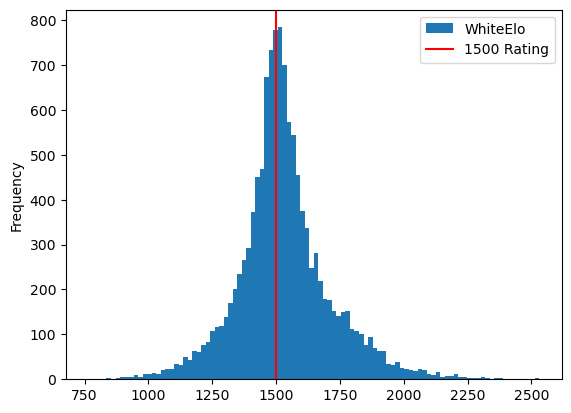

In [58]:
df[(df['w_had_1500']==1) & (df['WhiteElo']!=1500)]['WhiteElo'].plot(kind='hist', bins=100)
plt.axvline(x = 1500, color = 'r', label = '1500 Rating')
plt.legend();

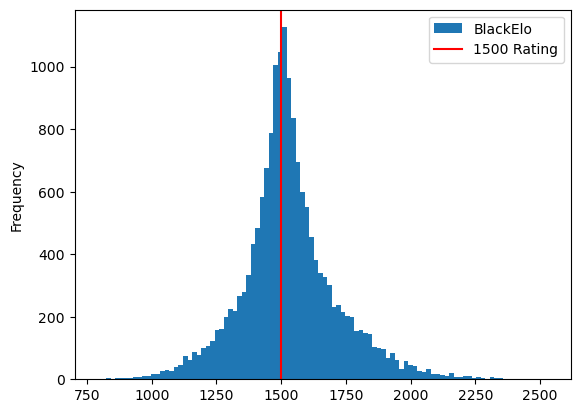

In [59]:
df[(df['b_had_1500']==1) & (df['BlackElo']!=1500)]['BlackElo'].plot(kind='hist', bins=100)
plt.axvline(x = 1500, color = 'r', label = '1500 Rating')
plt.legend();

### Distribution of rating gains/losses among new players

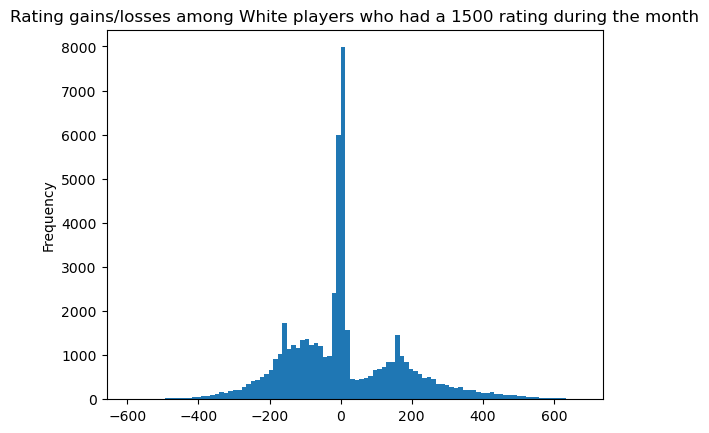

In [70]:
df[df['w_had_1500']==1]['WhiteRatingDiff'].plot(kind='hist', bins=100);
plt.title('Rating gains/losses among White players who had a 1500 rating during the month');

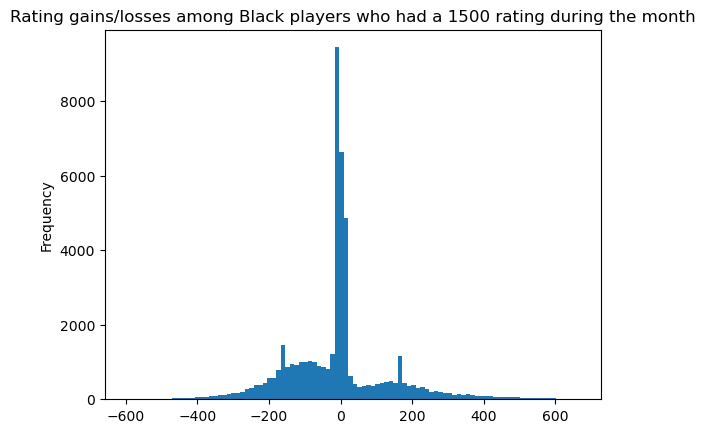

In [71]:
df[df['b_had_1500']==1]['BlackRatingDiff'].plot(kind='hist', bins=100);
plt.title('Rating gains/losses among Black players who had a 1500 rating during the month');

## Counting the number of games played by each player

In [60]:
white_game_counts = pd.DataFrame(df['White'].value_counts())
black_game_counts = pd.DataFrame(df['Black'].value_counts())
white_game_counts.head()

,White
sinkrafeas,91
Lacordaire,44
SarSamMel,39
korsox,38
Bloingo,36


In [61]:
black_game_counts.head()

,Black
galita,64
FigoFagot,39
Petruccco,39
obamaGANDON,39
dmaytry79,38


In [62]:
#Perform a full outer join
game_counts = white_game_counts.merge(black_game_counts, how='outer',
                        left_index=True,
                        right_index=True)
game_counts.tail()

,White,Black
zzz___zzz,1.0,NaN
zzz_fappa_zzz,NaN,1.0
zzzllzzz,1.0,NaN
zzzombie,NaN,6.0
zzzzzzr,1.0,NaN


In [63]:
#Fill in missing values with 0's, as a missing value means that player never played that color
game_counts.fillna(0, inplace=True)
game_counts.tail()

,White,Black
zzz___zzz,1.0,0.0
zzz_fappa_zzz,0.0,1.0
zzzllzzz,1.0,0.0
zzzombie,0.0,6.0
zzzzzzr,1.0,0.0


In [64]:
#Get the total number of games played by each player
game_counts['total_played'] = game_counts.apply(lambda row: row['White']+row['Black'], axis=1)
game_counts.tail()

,White,Black,total_played
zzz___zzz,1.0,0.0,1.0
zzz_fappa_zzz,0.0,1.0,1.0
zzzllzzz,1.0,0.0,1.0
zzzombie,0.0,6.0,6.0
zzzzzzr,1.0,0.0,1.0


In [66]:
#Add these game counts to our dataframe of games
df['w_total_played'] = df['White'].map(lambda x : game_counts['total_played'][x])
df['b_total_played'] = df['Black'].map(lambda x : game_counts['total_played'][x])

In [67]:
df.head(2)

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN,w_had_1500,b_had_1500,w_total_played,b_total_played
198,Blitz tournament,slichess,redscale,1-0,2016.06.30,22:00:51,1500,1385,128.0,-16.0,D06,Queen's Gambit Refused: Marshall Defense,180+2,Normal,1. d4 Nf6 2. c4 d5 3. cxd5 Nxd5 4. e4 Nf6 5. N...,1,1,2.0,7.0
205,Blitz,irakli112233,irakli1811,1-0,2016.06.30,22:00:54,1500,1500,NaN,NaN,A00,Van't Kruijs Opening,300+0,Normal,1. e3 f5 2. d3 g5 3. Qh5# 1-0,1,1,4.0,2.0


We're interested in studying those players who (1) are "new" in the sense of having had a 1500 rating at some point in the month and (2) played at least a certain number of games during that month.

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73469 entries, 198 to 6255987
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Event            73469 non-null  object 
 1   White            73469 non-null  object 
 2   Black            73469 non-null  object 
 3   Result           73469 non-null  object 
 4   UTCDate          73469 non-null  object 
 5   UTCTime          73469 non-null  object 
 6   WhiteElo         73469 non-null  int64  
 7   BlackElo         73469 non-null  int64  
 8   WhiteRatingDiff  72698 non-null  float64
 9   BlackRatingDiff  72698 non-null  float64
 10  ECO              73469 non-null  object 
 11  Opening          73469 non-null  object 
 12  TimeControl      73469 non-null  object 
 13  Termination      73469 non-null  object 
 14  AN               73469 non-null  object 
 15  w_had_1500       73469 non-null  int64  
 16  b_had_1500       73469 non-null  int64  
 17  w_total_

In [74]:
df['datetime'] = df.apply(lambda row : f"{row['UTCDate']} {row['UTCTime']}", axis=1)

In [75]:
df.head(2)

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN,w_had_1500,b_had_1500,w_total_played,b_total_played,datetime
198,Blitz tournament,slichess,redscale,1-0,2016.06.30,22:00:51,1500,1385,128.0,-16.0,D06,Queen's Gambit Refused: Marshall Defense,180+2,Normal,1. d4 Nf6 2. c4 d5 3. cxd5 Nxd5 4. e4 Nf6 5. N...,1,1,2.0,7.0,2016.06.30 22:00:51
205,Blitz,irakli112233,irakli1811,1-0,2016.06.30,22:00:54,1500,1500,NaN,NaN,A00,Van't Kruijs Opening,300+0,Normal,1. e3 f5 2. d3 g5 3. Qh5# 1-0,1,1,4.0,2.0,2016.06.30 22:00:54


In [76]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.head(2)

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN,w_had_1500,b_had_1500,w_total_played,b_total_played,datetime
198,Blitz tournament,slichess,redscale,1-0,2016.06.30,22:00:51,1500,1385,128.0,-16.0,D06,Queen's Gambit Refused: Marshall Defense,180+2,Normal,1. d4 Nf6 2. c4 d5 3. cxd5 Nxd5 4. e4 Nf6 5. N...,1,1,2.0,7.0,2016-06-30 22:00:51
205,Blitz,irakli112233,irakli1811,1-0,2016.06.30,22:00:54,1500,1500,NaN,NaN,A00,Van't Kruijs Opening,300+0,Normal,1. e3 f5 2. d3 g5 3. Qh5# 1-0,1,1,4.0,2.0,2016-06-30 22:00:54


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73469 entries, 198 to 6255987
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Event            73469 non-null  object        
 1   White            73469 non-null  object        
 2   Black            73469 non-null  object        
 3   Result           73469 non-null  object        
 4   UTCDate          73469 non-null  object        
 5   UTCTime          73469 non-null  object        
 6   WhiteElo         73469 non-null  int64         
 7   BlackElo         73469 non-null  int64         
 8   WhiteRatingDiff  72698 non-null  float64       
 9   BlackRatingDiff  72698 non-null  float64       
 10  ECO              73469 non-null  object        
 11  Opening          73469 non-null  object        
 12  TimeControl      73469 non-null  object        
 13  Termination      73469 non-null  object        
 14  AN               73469 non-null  o